In [1]:
import numpy as np
import pandas as pd
import datasets
import os
import scipy as sp
import gc
import time
import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
import yaml
from utils.utils import fetch_import_module

from time import gmtime, strftime
from tqdm import tqdm
from datasets import concatenate_datasets,Dataset,ClassLabel
from pipelines import alsafari_pipeline, alshalan_pipeline, albadi_pipeline, mulki_pipeline, mubarak_pipeline, chowdhury_pipeline, utils_pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import subprocess

os.environ['MKL_THREADING_LAYER'] = 'GNU'

from pathlib import Path

In [2]:
#!pip install datasets

# 3. Classification Perspective

## Data loading

In [ ]:
config = yaml.safe_load(open("config.yaml"))

In [ ]:
dataset_names = config['datasets']
data_sets_text = []
for dset in dataset_names:
    dset_module = fetch_import_module(dset)
    data_sets_text.append(dset_module.get_data_binary())


# Shammur 
data_chowdhury = chowdhury_pipeline.get_data_binary()



dataset_names = ['Chowdhury']

data_sets_text = [data_chowdhury]

## a) Cross-dataset performance

In [4]:
SEED =321
SPLIT_RATIO = 0.15
COMBINED_RATIO = 0.5
#MODEL_NAME= 'distilbert-base-uncased'
MODEL_NAME = 'asafaya/bert-base-arabic'
PATH = './tmp2/'
NUMBER_OF_TOKENS = 50
BATCH = 10
EPOCHS = 3

In [5]:
def cleanTweets(dataset):
    twitter_username_re = re.compile(r'@([A-Za-z0-9_]+)')
    hashtag_re = re.compile(r'\B(\#[a-zA-Z0-9]+\b)(?!;)')
    html_symbol_re = re.compile(r'&[^ ]+')
    url_re = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')
    for tweet in dataset:
        text = twitter_username_re.sub("[UNK]",tweet['text'])
        text = unicodedata.normalize('NFKC',text)
        text = text.replace('\n',' ')
        text = text.replace('RT ',' ')
        text = hashtag_re.sub("[UNK]",text)
        text = html_symbol_re.sub(" ",text)
        text = url_re.sub("[UNK]",text)
        tweet['text'] = text
    return dataset

In [6]:
def getPaths(root_path): 
    path_models = root_path+'models/'
    path_datasets =root_path+'datasets/'
    path_output = root_path+'outputs/'
    path_logs = root_path+'logs/'
    Path(path_models).mkdir(parents=True, exist_ok=True)
    Path(path_datasets).mkdir(parents=True, exist_ok=True)
    Path(path_output).mkdir(parents=True, exist_ok=True)
    Path(path_logs).mkdir(parents=True, exist_ok=True)
    return path_models,path_datasets,path_output,path_logs

def prepareData(data):
    data = cleanTweets(data)
    return convertLabelsToInt(utils_pipeline.get_huggingface_dataset_format(data))

def convertLabelsToInt(dataset):
    label_to_int = {
        "neutral": 0,
        "abusive": 1
    }
    dataset = dataset.map(lambda convertLabels: {"label": label_to_int[convertLabels["label"]]})
    return dataset

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=512, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

In [7]:
def plotMatrix(eval_metrics,labels,selected_type='f1', type_name=""):
    path_fig = "./results/"+strftime("%Y%m%d", gmtime())+ "-" + "-".join(labels).replace(" ","_")

    sns.set(font_scale=1.0)
    matrix = np.empty([len(eval_metrics),len(eval_metrics)])
    for i in range(len(eval_metrics)):
        for j in range(len(eval_metrics[i][selected_type])-1):
            matrix[i][j] = eval_metrics[i][selected_type][j]

    # calculate averages
    avg_classifiers = []
    avg_testsets = []

    for i in range(len(eval_metrics)):
        avg_classifiers.append(eval_metrics[i][selected_type][-1])   


    size = len(matrix[0])
    min_val = np.amin(matrix)
    max_val = np.amax(matrix) 

    avg_classifiers = np.asarray(avg_classifiers).reshape(size,1)

    fig = plt.figure(figsize=(6,5))
    ax1 = plt.subplot2grid((6,5), (0,0), colspan=4, rowspan=5)
    ax3 = plt.subplot2grid((6,5), (0,4), rowspan=5)

    cmap = "Blues"
    center = matrix[0][0]

    hm1 = sns.heatmap(matrix, ax=ax1,annot=True, fmt=".1%",vmin=min_val, vmax=max_val, cbar=False,cmap=cmap,square=True,xticklabels=labels, yticklabels=labels)
    hm2 = sns.heatmap(avg_classifiers, ax=ax3, annot=True, fmt=".1%", cbar=False, xticklabels=False, yticklabels=False,vmin=min_val, vmax=max_val,cmap=cmap,square=True)
    hm1.set_xticklabels(labels, rotation=90, ha='center')
    
    
    ax1.set_title(type_name)
    ax1.xaxis.tick_top()
    ax1.tick_params(length=0)
    ax1.set(xlabel='Test sets', ylabel='Classifiers')
    ax1.xaxis.set_label_coords(0.5, 1.30)

    ax3.set(xlabel='Combined\n test set', ylabel='')
    #ax3.xaxis.tick_top()
    ax3.xaxis.set_label_coords(0.5, 1.13)
    
    fig.savefig(path_fig + "-classification_cross_" + selected_type +".pdf", bbox_inches='tight', dpi=300)
    fig.savefig(path_fig + "-classification_cross_" + selected_type +".png", bbox_inches='tight', dpi=300)

--------------------------------------------------
Loading data sets...
--------------------------------------------------



--------------------------------------------------
Preparing data sets...
--------------------------------------------------
--------------------------------------------------
Training and evaluating classifiers...
--------------------------------------------------


100%|██████████| 6/6 [40:02<00:00, 400.36s/it]


Macro F1
Precision
Recall


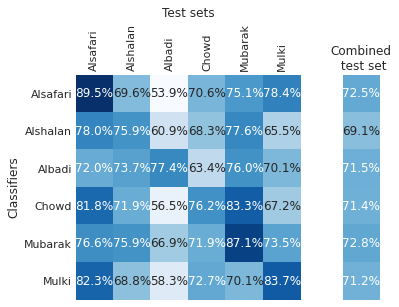

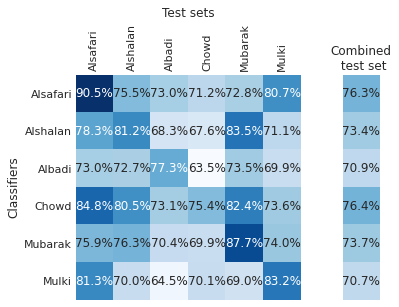

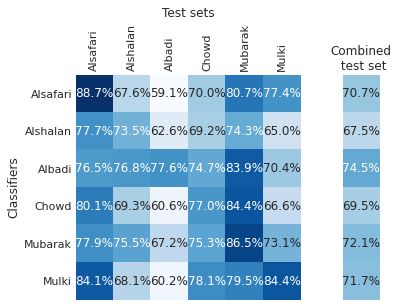

In [8]:
if __name__ == '__main__':
    
    # get paths and create folders
    path_models,path_datasets,path_output,path_logs =getPaths(PATH)

    print('-'*50)
    print('Loading data sets...')
    print('-'*50)
    
    # prepare data sets
    datasets = []
    for dataset in data_sets_text:
        datasets.append(prepareData(dataset))
    #w_data = prepareData(waseem_pipeline.get_data_binary())
    #d_data = prepareData(davidson_pipeline.get_data_binary())   
    #g_data = prepareData(golbeck_pipeline.get_data_binary())   
    #c_data = prepareData(charitidis_pipeline.get_data_binary())    
    #f_data = prepareData(founta_pipeline.get_data_binary())      

    #datasets = [c_data,d_data,f_data,g_data,w_data]
    #datasets = data_sets_text

    print('-'*50)
    print('Preparing data sets...')
    print('-'*50)
    
    # find lengths of smallest data set
    min_length = 99999999
    for dataset in datasets:
        min_length = min(min_length,len(dataset))
    size_train = round(min_length*(1-SPLIT_RATIO))
    size_test = min_length - size_train

    # split data into train and test set  
    training_sets = []
    validation_sets = []
    test_sets = []
    combined_test_set = None
    for i,dataset in enumerate(datasets):

        # split data sets and tokenize
        ## train/test split
        ds_dict_1 = dataset.train_test_split(test_size=size_test,train_size=size_train,shuffle=True,seed=SEED)
        ## train/val split
        ds_dict_2 = ds_dict_1['train'].train_test_split(test_size=0.2,shuffle=True,seed=SEED)

        path_training = path_datasets + dataset_names[i] + '_training'
        path_validation = path_datasets + dataset_names[i] + '_validation'
        path_test = path_datasets + dataset_names[i] + '_test'
        
        training_sets.append(path_training)
        validation_sets.append(path_validation)
        test_sets.append(path_test)

        Path(path_training).mkdir(parents=True, exist_ok=True)
        Path(path_validation).mkdir(parents=True, exist_ok=True)
        Path(path_test).mkdir(parents=True, exist_ok=True)
        ds_dict_2['train'].save_to_disk(path_training)
        ds_dict_2['test'].save_to_disk(path_validation)
        ds_dict_1['test'].save_to_disk(path_test)
        
        # combined test set
        ds_dict = ds_dict_1['test'].train_test_split(train_size=COMBINED_RATIO,shuffle=True,seed=SEED)
        if combined_test_set is None:
            combined_test_set = ds_dict['train']
        else:
            combined_test_set = concatenate_datasets([combined_test_set,ds_dict['train']])

    path_combined_test = path_datasets + 'combined_test'
    Path(path_combined_test).mkdir(parents=True, exist_ok=True)
    test_sets.append(path_combined_test)
    combined_test_set.save_to_disk(path_combined_test)
    
    print('-'*50)
    print('Training and evaluating classifiers...')
    print('-'*50)
    time.sleep(1)
    
    #print("path_models",path_models)
    #print("path_logs",path_logs)
    #print("path_models",path_models)
    #time.sleep(1)
    
    # train and evaluate classifiers
    for i in tqdm(range(len(datasets))):
        with open(path_logs+'stdout.log','a') as fout:
            with open(path_logs+'log.log','a') as ferr:
                proc = subprocess.call(['python', './processing/train_test_classifier.py', 
                         '-t',','.join(training_sets), 
                         '-v',','.join(validation_sets), 
                         '-e',','.join(test_sets), 
                         '-l',str(NUMBER_OF_TOKENS), 
                         '-b',str(BATCH), 
                         '-o',"{}{}_{}.pkl".format(path_output,str(i),dataset_names[i]), 
                         '-m',MODEL_NAME, 
                         '-p',"{}{}_{}_model".format(path_models,str(i),dataset_names[i]), 
                         '-g',path_logs,
                         '-c',str(EPOCHS),
                         '-i',str(i)],stdout=fout,stderr=ferr)
                         #'-i',str(i)])
                # reset file to read from it
                #fout.seek(0)
                # save output (if any) in variable
                #output=fout.read()

                # reset file to read from it
                #ferr.seek(0) 
                # save errors (if any) in variable
                #errors = ferr.read()
                time.sleep(5)
      
    evaluation_results = []
    for i in range(len(datasets)):
        file = "{}{}_{}.pkl".format(path_output,str(i),dataset_names[i])
        single_result = pickle.load(open(file, "rb"))
        evaluation_results.append(single_result)
    
    print("Macro F1")
    plotMatrix(evaluation_results,dataset_names,selected_type="f1")
    print("Precision")
    plotMatrix(evaluation_results,dataset_names,selected_type="precision")
    print("Recall")
    plotMatrix(evaluation_results,dataset_names,selected_type="recall")

import torch
import numpy as np
import pandas as pd
import datasets
import logging
import scipy as sp
import gc
import pickle
from numba import cuda

from tqdm import tqdm
from datasets import concatenate_datasets,Dataset,ClassLabel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, Trainer, TrainingArguments

i = 0
SEED =123
SPLIT_RATIO = 0.15
COMBINED_RATIO = 0.5
#MODEL_NAME= 'distilbert-base-uncased'
MODEL_NAME = 'asafaya/bert-base-arabic'
PATH = './tmp2/'
NUMBER_OF_TOKENS = 50
BATCH = 32
EPOCHS = 3

model_name =MODEL_NAME 
number_tokens = NUMBER_OF_TOKENS
batch = BATCH
path_model = './tmp2/models/0_Chowdhury_model/'
path_output = './tmp2/'
path_log = './tmp2/logs/'
epochs = EPOCHS

# define tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name,num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True)

# tokenize datasets
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

t_set = datasets.load_from_disk("./tmp2/datasets/Chowdhury_training/")

v_set = datasets.load_from_disk("./tmp2/datasets/Chowdhury_validation/")

train_dataset = t_set.map(tokenize, batched=True, batch_size=len(t_set))
val_dataset = v_set.map(tokenize, batched=True, batch_size=len(t_set))
#test_dataset = test_sets[i].map(tokenize, batched=True, batch_size=len(training_sets[i]))

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
#test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])


log = "Length of training set: " + str(len(train_dataset))
logging.warning(log)

# define trainer
training_args = TrainingArguments(
    output_dir=path_model,          # output directory
    num_train_epochs=epochs,              # total # of training epochs
    per_device_train_batch_size=batch,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=path_log,            # directory for storing logs
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
)

# train model
trainer.train()
